In [1]:
import gymnasium as gym
from gymnasium.spaces.box import Box

import torch
import torch.nn as nn
from torch.distributions import Categorical
import numpy as np
import torch.nn.functional as F

# device = "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from IPython import display
import cv2
import matplotlib.pyplot as plt

In [20]:
def _process_frame42(frame):
    frame = frame[34:34 + 160, :160]
    # Resize by half, then down to 42x42 (essentially mipmapping). If
    # we resize directly we lose pixels that, when mapped to 42x42,
    # aren't close enough to the pixel boundary.
    frame = cv2.resize(frame, (80, 80))
    frame = cv2.resize(frame, (42, 42))
    frame = frame.mean(2, keepdims=True)
    frame = frame.astype(np.float32)
    frame *= (1.0 / 255.0)
    frame = np.moveaxis(frame, -1, 0)
    return frame

class AtariRescale42x42(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(AtariRescale42x42, self).__init__(env)
        self.observation_space = Box(0.0, 1.0, [1, 42, 42])

    def observation(self, observation):
        return _process_frame42(observation)
    
class NormalizedEnv(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(NormalizedEnv, self).__init__(env)
        self.state_mean = 0
        self.state_std = 0
        self.alpha = 0.9999
        self.num_steps = 0

    def observation(self, observation):
        self.num_steps += 1
        self.state_mean = self.state_mean * self.alpha + \
            observation.mean() * (1 - self.alpha)
        self.state_std = self.state_std * self.alpha + \
            observation.std() * (1 - self.alpha)

        unbiased_mean = self.state_mean / (1 - pow(self.alpha, self.num_steps))
        unbiased_std = self.state_std / (1 - pow(self.alpha, self.num_steps))

        return (observation - unbiased_mean) / (unbiased_std + 1e-8)

max_episode_steps = 1000000
def create_atari_env(env_id):
    env = gym.make(env_id, max_episode_steps=max_episode_steps, difficulty = 1)
    # env = gym.make(env_id, max_episode_steps=max_episode_steps, render_mode="human")
    env = AtariRescale42x42(env)
    env = NormalizedEnv(env)
    return env


env = create_atari_env("ALE/Pong-v5")

In [21]:
state_dim = env.observation_space.shape
action_dim = env.action_space.n
state_dim, action_dim

((1, 42, 42), 6)

In [22]:
class ActorCritic(torch.nn.Module):
    def __init__(self, num_inputs=state_dim[0], action_dim=action_dim):
        super(ActorCritic, self).__init__()
        self.conv1 = nn.Conv2d(num_inputs, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)

        # self.lstm = nn.LSTMCell(32 * 3 * 3, 256)
        self.fc = nn.Linear(32 * 3 * 3, 256)

        num_outputs = action_dim
        self.critic_linear = nn.Linear(256, 1)
        self.actor_linear = nn.Linear(256, num_outputs)
        self.soft = nn.Softmax(dim=-1)


        self.train()

    def forward(self, state):
        # state = torch.from_numpy(state)
        x = F.elu(self.conv1(state))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))

        x = x.view(-1, 32 * 3 * 3)
        x = self.fc(x)
        action_probs = self.soft(self.actor_linear(x))
        state_val = self.critic_linear(x)
        return action_probs, state_val

    def act(self, state):
        action_probs, state_val = self(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        action_logprob = dist.log_prob(action)

        return action.detach(), action_logprob.detach(), state_val.detach()

    def evaluate(self, state, action):  
        action_probs, state_val = self(state)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        return action_logprobs, state_val, dist_entropy


# state, _ = env.reset()
# state = torch.from_numpy(state)
# model = ActorCritic()
# cx = torch.zeros(1, 256).float()
# hx = torch.zeros(1, 256).float()
# # action_probs, state_val, (hx, cx) = model((state, (hx, cx)))
# # action_probs.shape, state_val.shape
# action, action_logprob, state_val = model.act(state)
# action_logprobs, state_val, dist_entropy = model.evaluate(state, action)

In [23]:
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []
    
    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]

In [28]:
class PPO:
    def __init__(self, state_dim=state_dim[0], action_dim=action_dim, lr_actor=0.00009, gamma=0.99 , K_epochs=80, eps_clip=0.2):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.buffer = RolloutBuffer()
        self.time_buffer_clear = 0

        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr_actor)

        self.policy_old = ActorCritic(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()

    def select_action(self, state):
        with torch.no_grad():
            state = torch.from_numpy(state).to(device)
            action, action_logprob, state_val = self.policy_old.act(state)
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.item()

    def update(self):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        rewards = torch.tensor(rewards).float().to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        old_states = torch.stack(self.buffer.states, dim=0).detach().to(device)
        # old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        advantages = rewards.detach() - old_state_values.detach()

        # print(old_states.shape, old_actions.shape, old_logprobs.shape, old_state_values.shape, advantages.shape, rewards.shape)
        for _ in range(self.K_epochs):
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            state_values = torch.squeeze(state_values)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())

        self.buffer.clear()
        # if self.time_buffer_clear == 0:
        #     self.time_buffer_clear = 0
        #     self.buffer.clear()
        # self.time_buffer_clear  += 1

    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
  
    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        
ppo_agent = PPO()
ppo_agent.load(f"ppo_actor.pt")
# list_episodes_reward = []
# time_step = 0
# i_episode = 0

Episode: 814 Timestep: 1838000 Reward: 1.5


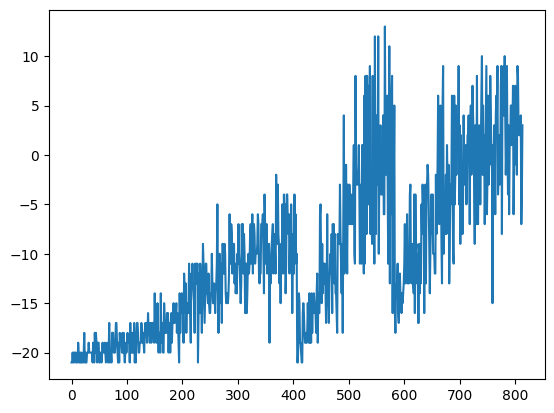

OutOfMemoryError: CUDA out of memory. Tried to allocate 540.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 2.97 GiB is allocated by PyTorch, and 90.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [29]:
max_ep_len = 10000
update_timestep = 10000#max_ep_len * 4 
max_training_timesteps = int(3e6) 


print_freq = 2000
save_model_freq = update_timestep

print_running_reward = 0
print_running_episodes = 0
# done = True


while time_step <= max_training_timesteps:
    state, _ = env.reset()
    current_ep_reward = 0
    for t in range(1, max_ep_len+1):


        action = ppo_agent.select_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        time_step += 1
        current_ep_reward += reward


        if time_step % update_timestep == 0:
            ppo_agent.update()

        if time_step % print_freq == 0:
            display.clear_output()
            print_avg_reward = print_running_reward / (print_running_episodes+1)
            print_avg_reward = round(print_avg_reward, 2)
            print(f"Episode: {i_episode} Timestep: {time_step} Reward: {print_avg_reward}")
            print_running_reward = 0
            print_running_episodes = 0
            plt.plot(list_episodes_reward)
            plt.show()

        if time_step % save_model_freq == 0:
            print('------------------------')
            ppo_agent.save(f"ppo_actor.pt")
            print('model saved')
            print('------------------------')
        
        if done:
            break
    
    list_episodes_reward.append(current_ep_reward)
    print_running_reward += current_ep_reward
    print_running_episodes += 1

    i_episode += 1
